In [1]:
import os

# --- 1. Define Paths for Kaggle Input Directory ---
# This is the path Kaggle creates for your dataset.
# The dataset name is 'karyogram-cv-camp' and the top folder inside is '2025_Karyogram_CV_Camp'
base_path = '/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp'
images_path = os.path.join(base_path, '24_chromosomes_object', 'images')
annotations_path = os.path.join(base_path, '24_chromosomes_object', 'annotations')
train_file = os.path.join(base_path, 'train.txt')

# --- 2. Run Verification Checks ---
print("--- Verifying Dataset Paths ---")

# Check if the main folders exist
print(f"Base folder exists: {os.path.exists(base_path)} -> {base_path}")
print(f"Images folder exists: {os.path.exists(images_path)}")
print(f"Annotations folder exists: {os.path.exists(annotations_path)}")
print(f"train.txt file exists: {os.path.exists(train_file)}")

# --- 3. Preview Contents ---
if os.path.exists(train_file):
    print("\n--- Previewing train.txt ---")
    try:
        with open(train_file, 'r') as f:
            lines = [f.readline().strip() for _ in range(5)]
        print("First 5 image names:", lines)
        print(" Verification successful! You can now proceed to preprocessing.")
    except Exception as e:
        print(f" Error reading train.txt: {e}")
else:
    print("\n Verification failed. Please check your dataset name and paths.")

--- Verifying Dataset Paths ---
Base folder exists: True -> /kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp
Images folder exists: True
Annotations folder exists: True
train.txt file exists: True

--- Previewing train.txt ---
First 5 image names: ['103064', '103071', '103072', '103081', '103082']
 Verification successful! You can now proceed to preprocessing.


In [2]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil

# --- 1. Define Paths for Kaggle ---
# This is the verified input path from the previous cell
BASE_PATH = '/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp'

# This is the writable output directory on Kaggle
OUTPUT_PATH = '/kaggle/working/processed_data'

IMAGE_SIZE = (128, 128)
MIN_CROP_DIMENSION = 10

# Clean up any previous runs to ensure a fresh start
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
    print(" Cleaned up previous processed_data folder.")

# --- 2. Read file list and create train/validation splits ---
train_file_list = os.path.join(BASE_PATH, 'train.txt')
with open(train_file_list, 'r') as f:
    all_train_names = [line.strip() for line in f]

train_names, val_names = train_test_split(all_train_names, test_size=0.2, random_state=42)

print(f" Total images for processing: {len(all_train_names)}")
print(f"   - Training set size: {len(train_names)}")
print(f"   - Validation set size: {len(val_names)}")

# --- 3. Define the main processing function ---
def process_and_save_images(image_names, set_name):
    """
    Processes a list of image names, extracts, cleans, and saves chromosome crops.
    """
    images_path = os.path.join(BASE_PATH, "24_chromosomes_object", "images")
    annotations_path = os.path.join(BASE_PATH, "24_chromosomes_object", "annotations")

    for image_name in tqdm(image_names, desc=f"Processing {set_name} set"):
        image_path = os.path.join(images_path, image_name + ".jpg")
        xml_path = os.path.join(annotations_path, image_name + ".xml")

        if not os.path.exists(image_path) or not os.path.exists(xml_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue
        
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
        except ET.ParseError:
            continue

        for i, member in enumerate(root.findall('object')):
            try:
                label = member.find('name').text.strip().upper()
                bndbox = member.find('bndbox')
                xmin, ymin = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
                xmax, ymax = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
            except (AttributeError, ValueError):
                continue

            # Crop the chromosome
            cropped_chromosome = image[ymin:ymax, xmin:xmax]
            
            # Handle small or invalid crops
            if cropped_chromosome.size == 0 or cropped_chromosome.shape[0] < MIN_CROP_DIMENSION or cropped_chromosome.shape[1] < MIN_CROP_DIMENSION:
                continue

            # Create the destination directory in the /kaggle/working/ folder
            label_dir = os.path.join(OUTPUT_PATH, set_name, label)
            os.makedirs(label_dir, exist_ok=True)
            
            # Resize the valid crop
            resized_chromosome = cv2.resize(cropped_chromosome, IMAGE_SIZE)

            # Save the final, processed image
            save_filename = f"{image_name}_crop_{i}.png"
            save_path = os.path.join(label_dir, save_filename)
            cv2.imwrite(save_path, resized_chromosome)

# --- 4. Run the processing for both training and validation sets ---
process_and_save_images(train_names, "train")
process_and_save_images(val_names, "validation")

print("\n All preprocessing is complete! Your dataset is ready for model training in '/kaggle/working/processed_data'.")

 Total images for processing: 3750
   - Training set size: 3000
   - Validation set size: 750


Processing validation set: 100%|██████████| 750/750 [00:36<00:00, 20.43it/s]


 All preprocessing is complete! Your dataset is ready for model training in '/kaggle/working/processed_data'.


2025-11-26 10:59:54.325312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764154794.512291      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764154794.564091      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Found 137645 files belonging to 24 classes.


I0000 00:00:1764154814.606291      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764154814.606903      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 34410 files belonging to 24 classes.
Classes found: ['A1', 'A2', 'A3', 'B4', 'B5', 'C10', 'C11', 'C12', 'C6', 'C7', 'C8', 'C9', 'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
✅ Class names saved to class_names.json

Calculated class weights to handle imbalance:
{'A1': '0.96', 'A2': '0.96', 'A3': '0.96', 'B4': '0.96', 'B5': '0.96', 'C10': '0.96', 'C11': '0.96', 'C12': '0.96', 'C6': '0.96', 'C7': '0.96', 'C8': '0.96', 'C9': '0.96', 'D13': '0.96', 'D14': '0.96', 'D15': '0.96', 'E16': '0.96', 'E17': '0.96', 'E18': '0.96', 'F19': '0.96', 'F20': '0.96', 'G21': '0.96', 'G22': '0.96', 'X': '1.31', 'Y': '3.76'}

 Data pipeline is ready with augmentation and class weights.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 Model built for initial training.

 Starting initial model training (frozen base)...
Epoch 1/20


I0000 00:00:1764154825.461592      68 service.cc:148] XLA service 0x7b6f700535a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764154825.462091      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764154825.462103      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764154826.605047      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/4302 ━━━━━━━━━━━━━━━━━━━━ 1:35 22ms/step - accuracy: 0.0617 - loss: 3.8065

I0000 00:00:1764154830.492566      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1560 - loss: 2.5735

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 283s 64ms/step - accuracy: 0.1560 - loss: 2.5734 - val_accuracy: 0.2180 - val_loss: 2.3040 - learning_rate: 0.0010
Epoch 2/20
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2024 - loss: 2.3467

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 263s 61ms/step - accuracy: 0.2024 - loss: 2.3467 - val_accuracy: 0.2341 - val_loss: 2.2403 - learning_rate: 0.0010
Epoch 3/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2153 - loss: 2.3149

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 264s 61ms/step - accuracy: 0.2153 - loss: 2.3149 - val_accuracy: 0.2480 - val_loss: 2.2053 - learning_rate: 0.0010
Epoch 4/20
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2186 - loss: 2.2954

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 270s 63ms/step - accuracy: 0.2186 - loss: 2.2954 - val_accuracy: 0.2618 - val_loss: 2.1842 - learning_rate: 0.0010
Epoch 5/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 318s 62ms/step - accuracy: 0.2242 - loss: 2.2849 - val_accuracy: 0.2584 - val_loss: 2.1899 - learning_rate: 0.0010
Epoch 6/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.2255 - loss: 2.2792 - val_accuracy: 0.2562 - val_loss: 2.1897 - learning_rate: 0.0010
Epoch 7/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2274 - loss: 2.2668

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 269s 62ms/step - accuracy: 0.2274 - loss: 2.2669 - val_accuracy: 0.2652 - val_loss: 2.1568 - learning_rate: 0.0010
Epoch 8/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 268s 62ms/step - accuracy: 0.2292 - loss: 2.2640 - val_accuracy: 0.2594 - val_loss: 2.1795 - learning_rate: 0.0010
Epoch 9/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 321s 62ms/step - accuracy: 0.2290 - loss: 2.2672 - val_accuracy: 0.2665 - val_loss: 2.1700 - learning_rate: 0.0010
Epoch 10/20
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2333 - loss: 2.2532
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 264s 61ms/step - accuracy: 0.2333 - loss: 2.2532 - val_accuracy: 0.2556 - val_loss: 2.1840 - learning_rate: 0.0010
Epoch 11/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2452 - loss: 2.2230

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 264s 61ms/step - accuracy: 0.2452 - loss: 2.2230 - val_accuracy: 0.2879 - val_loss: 2.1116 - learning_rate: 2.0000e-04
Epoch 12/20
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2510 - loss: 2.2015

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.2510 - loss: 2.2015 - val_accuracy: 0.2903 - val_loss: 2.1039 - learning_rate: 2.0000e-04
Epoch 13/20
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2548 - loss: 2.1954

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.2548 - loss: 2.1954 - val_accuracy: 0.2899 - val_loss: 2.1014 - learning_rate: 2.0000e-04
Epoch 14/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2566 - loss: 2.1934

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.2566 - loss: 2.1934 - val_accuracy: 0.2921 - val_loss: 2.0998 - learning_rate: 2.0000e-04
Epoch 15/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.2536 - loss: 2.1942 - val_accuracy: 0.2900 - val_loss: 2.1017 - learning_rate: 2.0000e-04
Epoch 16/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2561 - loss: 2.1872

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.2561 - loss: 2.1872 - val_accuracy: 0.2916 - val_loss: 2.0985 - learning_rate: 2.0000e-04
Epoch 17/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.2546 - loss: 2.1923 - val_accuracy: 0.2914 - val_loss: 2.1013 - learning_rate: 2.0000e-04
Epoch 18/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2590 - loss: 2.1871

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.2590 - loss: 2.1871 - val_accuracy: 0.2917 - val_loss: 2.0966 - learning_rate: 2.0000e-04
Epoch 19/20
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2557 - loss: 2.1834

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - accuracy: 0.2557 - loss: 2.1834 - val_accuracy: 0.2932 - val_loss: 2.0951 - learning_rate: 2.0000e-04
Epoch 20/20
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 266s 62ms/step - accuracy: 0.2591 - loss: 2.1832 - val_accuracy: 0.2904 - val_loss: 2.1029 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 19.

 Starting fine-tuning (unfreezing top layers)...
Epoch 21/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 319s 67ms/step - accuracy: 0.1258 - loss: 11.4009 - val_accuracy: 0.2217 - val_loss: 2.3028 - learning_rate: 1.0000e-05
Epoch 22/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2162 - loss: 2.3165

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.2162 - loss: 2.3165 - val_accuracy: 0.3307 - val_loss: 1.9530 - learning_rate: 1.0000e-05
Epoch 23/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2974 - loss: 2.0544

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.2974 - loss: 2.0544 - val_accuracy: 0.4181 - val_loss: 1.6916 - learning_rate: 1.0000e-05
Epoch 24/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3587 - loss: 1.8604

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 279s 65ms/step - accuracy: 0.3587 - loss: 1.8604 - val_accuracy: 0.4854 - val_loss: 1.4993 - learning_rate: 1.0000e-05
Epoch 25/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4218 - loss: 1.6895

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.4218 - loss: 1.6895 - val_accuracy: 0.5348 - val_loss: 1.3581 - learning_rate: 1.0000e-05
Epoch 26/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4731 - loss: 1.5515

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.4731 - loss: 1.5515 - val_accuracy: 0.5931 - val_loss: 1.2162 - learning_rate: 1.0000e-05
Epoch 27/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5274 - loss: 1.4096

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.5274 - loss: 1.4096 - val_accuracy: 0.6442 - val_loss: 1.0854 - learning_rate: 1.0000e-05
Epoch 28/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5814 - loss: 1.2717

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.5814 - loss: 1.2717 - val_accuracy: 0.6977 - val_loss: 0.9389 - learning_rate: 1.0000e-05
Epoch 29/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6324 - loss: 1.1317

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 273s 63ms/step - accuracy: 0.6324 - loss: 1.1316 - val_accuracy: 0.7435 - val_loss: 0.7961 - learning_rate: 1.0000e-05
Epoch 30/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6823 - loss: 0.9938

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.6823 - loss: 0.9938 - val_accuracy: 0.7811 - val_loss: 0.6883 - learning_rate: 1.0000e-05
Epoch 31/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7259 - loss: 0.8689

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.7259 - loss: 0.8689 - val_accuracy: 0.8124 - val_loss: 0.5921 - learning_rate: 1.0000e-05
Epoch 32/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7580 - loss: 0.7739

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.7580 - loss: 0.7739 - val_accuracy: 0.8367 - val_loss: 0.5224 - learning_rate: 1.0000e-05
Epoch 33/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7872 - loss: 0.6891

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 279s 65ms/step - accuracy: 0.7872 - loss: 0.6891 - val_accuracy: 0.8591 - val_loss: 0.4584 - learning_rate: 1.0000e-05
Epoch 34/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8089 - loss: 0.6223

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.8089 - loss: 0.6223 - val_accuracy: 0.8696 - val_loss: 0.4223 - learning_rate: 1.0000e-05
Epoch 35/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8262 - loss: 0.5715

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.8262 - loss: 0.5715 - val_accuracy: 0.8836 - val_loss: 0.3768 - learning_rate: 1.0000e-05
Epoch 36/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8460 - loss: 0.5105

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.8460 - loss: 0.5105 - val_accuracy: 0.8945 - val_loss: 0.3445 - learning_rate: 1.0000e-05
Epoch 37/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8569 - loss: 0.4772

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.8569 - loss: 0.4772 - val_accuracy: 0.9027 - val_loss: 0.3165 - learning_rate: 1.0000e-05
Epoch 38/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8677 - loss: 0.4448

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.8677 - loss: 0.4448 - val_accuracy: 0.9108 - val_loss: 0.2920 - learning_rate: 1.0000e-05
Epoch 39/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8769 - loss: 0.4141

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.8769 - loss: 0.4141 - val_accuracy: 0.9164 - val_loss: 0.2724 - learning_rate: 1.0000e-05
Epoch 40/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8869 - loss: 0.3810

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.8869 - loss: 0.3810 - val_accuracy: 0.9168 - val_loss: 0.2713 - learning_rate: 1.0000e-05
Epoch 41/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8918 - loss: 0.3626

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.8918 - loss: 0.3626 - val_accuracy: 0.9231 - val_loss: 0.2502 - learning_rate: 1.0000e-05
Epoch 42/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8983 - loss: 0.3445

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 321s 64ms/step - accuracy: 0.8983 - loss: 0.3445 - val_accuracy: 0.9295 - val_loss: 0.2361 - learning_rate: 1.0000e-05
Epoch 43/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9042 - loss: 0.3260

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9042 - loss: 0.3260 - val_accuracy: 0.9328 - val_loss: 0.2218 - learning_rate: 1.0000e-05
Epoch 44/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9108 - loss: 0.3071

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 278s 65ms/step - accuracy: 0.9108 - loss: 0.3071 - val_accuracy: 0.9349 - val_loss: 0.2143 - learning_rate: 1.0000e-05
Epoch 45/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9127 - loss: 0.2954

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9127 - loss: 0.2954 - val_accuracy: 0.9376 - val_loss: 0.2043 - learning_rate: 1.0000e-05
Epoch 46/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9166 - loss: 0.2830

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9166 - loss: 0.2830 - val_accuracy: 0.9403 - val_loss: 0.1989 - learning_rate: 1.0000e-05
Epoch 47/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9203 - loss: 0.2724 - val_accuracy: 0.9403 - val_loss: 0.1992 - learning_rate: 1.0000e-05
Epoch 48/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9253 - loss: 0.2579

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 278s 65ms/step - accuracy: 0.9253 - loss: 0.2579 - val_accuracy: 0.9439 - val_loss: 0.1879 - learning_rate: 1.0000e-05
Epoch 49/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9271 - loss: 0.2502

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9271 - loss: 0.2502 - val_accuracy: 0.9452 - val_loss: 0.1816 - learning_rate: 1.0000e-05
Epoch 50/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9300 - loss: 0.2425

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9300 - loss: 0.2425 - val_accuracy: 0.9475 - val_loss: 0.1771 - learning_rate: 1.0000e-05
Epoch 51/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9332 - loss: 0.2310

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 273s 63ms/step - accuracy: 0.9332 - loss: 0.2310 - val_accuracy: 0.9487 - val_loss: 0.1717 - learning_rate: 1.0000e-05
Epoch 52/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9356 - loss: 0.2222

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 272s 63ms/step - accuracy: 0.9356 - loss: 0.2222 - val_accuracy: 0.9520 - val_loss: 0.1646 - learning_rate: 1.0000e-05
Epoch 53/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9355 - loss: 0.2203

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 273s 63ms/step - accuracy: 0.9355 - loss: 0.2203 - val_accuracy: 0.9525 - val_loss: 0.1625 - learning_rate: 1.0000e-05
Epoch 54/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9384 - loss: 0.2105

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9384 - loss: 0.2105 - val_accuracy: 0.9519 - val_loss: 0.1619 - learning_rate: 1.0000e-05
Epoch 55/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9410 - loss: 0.2036

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9410 - loss: 0.2036 - val_accuracy: 0.9548 - val_loss: 0.1567 - learning_rate: 1.0000e-05
Epoch 56/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9423 - loss: 0.1996 - val_accuracy: 0.9536 - val_loss: 0.1578 - learning_rate: 1.0000e-05
Epoch 57/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9442 - loss: 0.1950

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9442 - loss: 0.1950 - val_accuracy: 0.9559 - val_loss: 0.1486 - learning_rate: 1.0000e-05
Epoch 58/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 273s 63ms/step - accuracy: 0.9460 - loss: 0.1870 - val_accuracy: 0.9561 - val_loss: 0.1495 - learning_rate: 1.0000e-05
Epoch 59/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9477 - loss: 0.1805

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9477 - loss: 0.1805 - val_accuracy: 0.9566 - val_loss: 0.1481 - learning_rate: 1.0000e-05
Epoch 60/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9484 - loss: 0.1786

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 273s 64ms/step - accuracy: 0.9484 - loss: 0.1786 - val_accuracy: 0.9590 - val_loss: 0.1398 - learning_rate: 1.0000e-05
Epoch 61/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9508 - loss: 0.1714

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9508 - loss: 0.1714 - val_accuracy: 0.9605 - val_loss: 0.1356 - learning_rate: 1.0000e-05
Epoch 62/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9517 - loss: 0.1684 - val_accuracy: 0.9597 - val_loss: 0.1357 - learning_rate: 1.0000e-05
Epoch 63/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9537 - loss: 0.1619 - val_accuracy: 0.9603 - val_loss: 0.1370 - learning_rate: 1.0000e-05
Epoch 64/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9533 - loss: 0.1597

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 322s 64ms/step - accuracy: 0.9533 - loss: 0.1597 - val_accuracy: 0.9615 - val_loss: 0.1327 - learning_rate: 1.0000e-05
Epoch 65/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9545 - loss: 0.1566

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9545 - loss: 0.1566 - val_accuracy: 0.9616 - val_loss: 0.1318 - learning_rate: 1.0000e-05
Epoch 66/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9545 - loss: 0.1564

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9545 - loss: 0.1564 - val_accuracy: 0.9625 - val_loss: 0.1300 - learning_rate: 1.0000e-05
Epoch 67/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9557 - loss: 0.1516

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9557 - loss: 0.1516 - val_accuracy: 0.9636 - val_loss: 0.1295 - learning_rate: 1.0000e-05
Epoch 68/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9562 - loss: 0.1466

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9562 - loss: 0.1466 - val_accuracy: 0.9641 - val_loss: 0.1273 - learning_rate: 1.0000e-05
Epoch 69/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9595 - loss: 0.1418

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9595 - loss: 0.1418 - val_accuracy: 0.9641 - val_loss: 0.1268 - learning_rate: 1.0000e-05
Epoch 70/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9583 - loss: 0.1444

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9583 - loss: 0.1444 - val_accuracy: 0.9656 - val_loss: 0.1237 - learning_rate: 1.0000e-05
Epoch 71/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9589 - loss: 0.1432

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9589 - loss: 0.1432 - val_accuracy: 0.9662 - val_loss: 0.1199 - learning_rate: 1.0000e-05
Epoch 72/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9607 - loss: 0.1371

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s 65ms/step - accuracy: 0.9607 - loss: 0.1371 - val_accuracy: 0.9668 - val_loss: 0.1194 - learning_rate: 1.0000e-05
Epoch 73/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9623 - loss: 0.1305 - val_accuracy: 0.9661 - val_loss: 0.1259 - learning_rate: 1.0000e-05
Epoch 74/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9616 - loss: 0.1325

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9616 - loss: 0.1325 - val_accuracy: 0.9664 - val_loss: 0.1192 - learning_rate: 1.0000e-05
Epoch 75/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9626 - loss: 0.1296

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9626 - loss: 0.1296 - val_accuracy: 0.9670 - val_loss: 0.1173 - learning_rate: 1.0000e-05
Epoch 76/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9636 - loss: 0.1268 - val_accuracy: 0.9657 - val_loss: 0.1228 - learning_rate: 1.0000e-05
Epoch 77/80
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9638 - loss: 0.1268 - val_accuracy: 0.9672 - val_loss: 0.1178 - learning_rate: 1.0000e-05
Epoch 78/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9650 - loss: 0.1231

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9650 - loss: 0.1231 - val_accuracy: 0.9679 - val_loss: 0.1163 - learning_rate: 1.0000e-05
Epoch 79/80
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9649 - loss: 0.1238

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9649 - loss: 0.1238 - val_accuracy: 0.9686 - val_loss: 0.1155 - learning_rate: 1.0000e-05
Epoch 80/80
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9657 - loss: 0.1195

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 276s 64ms/step - accuracy: 0.9657 - loss: 0.1195 - val_accuracy: 0.9684 - val_loss: 0.1124 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 80.

 Model fine-tuning complete!


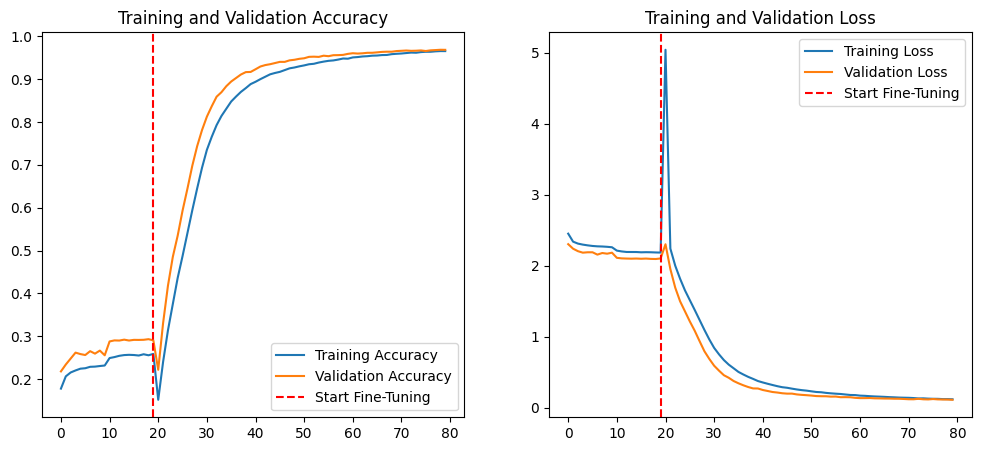


 Evaluating the fine-tuned model on the validation set...
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9663 - loss: 0.1141



 Final Validation Accuracy: 96.84%
 Final Validation Loss: 0.1124

 Final, best model saved to final_chromosome_classifier_fine_tuned.h5


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, Rescaling, RandomZoom, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import numpy as np
import json

# --- 1. Define Parameters and Paths (Updated for Kaggle) ---
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 24
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 60

# Paths now point to the /kaggle/working/ directory
train_path = "/kaggle/working/processed_data/train"
val_path = "/kaggle/working/processed_data/validation"

# --- 2. Load Datasets ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, labels='inferred', label_mode='categorical', image_size=IMAGE_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path, labels='inferred', label_mode='categorical', image_size=IMAGE_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False
)
class_names = train_ds.class_names
print("Classes found:", class_names)

# Save the class names for the evaluation script
with open('/kaggle/working/class_names.json', 'w') as f:
    json.dump(class_names, f)
print("✅ Class names saved to class_names.json")

# --- 3. Calculate Class Weights for Imbalance ---
sample_counts = [len(os.listdir(os.path.join(train_path, c))) for c in class_names]
total_samples = sum(sample_counts)
class_weights = {}
for i, count in enumerate(sample_counts):
    class_weights[i] = total_samples / (NUM_CLASSES * count)
print("\nCalculated class weights to handle imbalance:")
print({class_names[i]: f"{w:.2f}" for i, w in class_weights.items()})

# --- 4. Create Efficient Data Pipeline with Better Augmentation ---
rescale = Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.1),
    RandomContrast(0.1),
])

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    # .cache() should work fine on Kaggle and will speed up training
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
print("\n Data pipeline is ready with augmentation and class weights.")

# --- 5. Build Model for Transfer Learning ---
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False




# After (Added Dense layer and adjusted Dropout)
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
# --- New Head Start ---
x = Dense(256, activation='relu')(x) # Added new Dense layer
x = Dropout(0.5)(x) # Increased dropout rate for the larger head
# --- New Head End ---
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)



model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print("\n Model built for initial training.")

# --- 6. Define Smart Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_chromosome_model.h5", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# --- 7. Initial Training ---
print("\n Starting initial model training (frozen base)...")
history = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

# --- 8. Fine-Tuning Phase ---
print("\n Starting fine-tuning (unfreezing top layers)...")
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate the correct starting epoch
start_epoch = history.epoch[-1] + 1

history_fine = model.fit(
    train_ds,
    epochs=start_epoch + FINE_TUNE_EPOCHS, # Total epochs to run until
    initial_epoch=start_epoch, # Epoch to start from
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)
print("\n Model fine-tuning complete!")


# --- 9. Visualize Training and Fine-Tuning History ---


acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
if len(history.history['accuracy']) < INITIAL_EPOCHS:
    plt.axvline(len(history.history['accuracy'])-1, color='r', linestyle='--', label='Start Fine-Tuning')
else:
    plt.axvline(INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
if len(history.history['loss']) < INITIAL_EPOCHS:
    plt.axvline(len(history.history['loss'])-1, color='r', linestyle='--', label='Start Fine-Tuning')
else:
    plt.axvline(INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# --- 10. Evaluate and Save Final Model ---
print("\n Evaluating the fine-tuned model on the validation set...")
loss, accuracy = model.evaluate(val_ds, verbose=1)
print(f"\n Final Validation Accuracy: {accuracy*100:.2f}%")
print(f" Final Validation Loss: {loss:.4f}")

model.save("final_chromosome_classifier_fine_tuned.h5")
print("\n Final, best model saved to final_chromosome_classifier_fine_tuned.h5")

